In [1]:
from modules import *


In [177]:
class PowerSpectrum(object):
    ''' Power spectrum object. '''
    def __init__(self):

        self.A = 1.
        self.normalize()
        
    def W_tilde(self, kR):
        ''' Fourier transform of the top-hat window function. '''
        W_tilde = (np.sin(kR) - kR * np.cos(kR)) * (3 / kR**3)
        return W_tilde
        
    def Omega_m(self, a_exp):
        ''' Density parameter of matter. '''
        Omega_m = const.Omega_m0 / a_exp**3 / (const.Omega_m0 / a_exp**3 + const.Omega_k0 / a_exp**2 + const.Omega_L0)
        return Omega_m
    
    def Omega_L(self, a_exp):
        ''' Density parameter of dark energy. '''
        Omega_L = const.Omega_L0 / (const.Omega_m0 / a_exp**3 + const.Omega_k0 / a_exp**2 + const.Omega_L0)
        return Omega_L
    
    def D(self, a_exp):
        ''' 
        Linear growth rate.
        
        From Eisenstein&Hu1998 eq. A4-A6 (https://arxiv.org/pdf/astro-ph/9709112.pdf)
        '''
        Omega_m, Omega_L = self.Omega_m(a_exp), self.Omega_L(a_exp)
        D = a_exp * 5/2 * Omega_m / (Omega_m**(4/7) - Omega_L + (1 + Omega_m/2) * (1 + Omega_L/70))
        return D
    
    def T0(self, k):
        ''' 
        Transfer function.
        
        From Eisenstein&Hu1998 eq. 28-29 (https://arxiv.org/pdf/astro-ph/9709112.pdf)
        '''
        Lambda = const.Omega_m0 * const.h0
        q = k / Lambda# / (const.h0 * const.Mpc)
        C0 = 14.2 + 731 / (1 + 62.5 * q)
        L0 = np.log(2 * np.e + 1.8 * q)
        T0 = L0 / (L0 + C0 * q**2)
        return T0
    
    def P(self, k, a_exp):
        ''' Power spectrum. '''
        P = self.A * k**const.n_PS * self.T0(k)**2 * self.D(a_exp)**2
        return P
    
    def R(self, M, a_exp):
        ''' Top-hat filter radius. '''
        rho_m = const.Omega_m0 * const.rho_crit_0 / a_exp**3
        R = (3/(4*np.pi) * M / rho_m)**(1/3)
        return R
    
    def delta_crit(self, a_exp):
        ''' Critical overdensity for collapse. '''
        delta_crit = 1.686 / self.D(a_exp)
        return delta_crit
    
    def sigmaR(self, R, a_exp):
        ''' RMS of overdensity field as a function of filter radius. '''
        integrand = lambda k: k**2 * self.P(k, a_exp) * self.W_tilde(k * R)**2
        if type(R) in [float, int]:
            sigmaR = np.sqrt(quad(integrand, 0, np.inf)[0] / (2 * np.pi**2))
        elif type(R) == np.ndarray:
            sigmaR = np.sqrt(quad_vec(integrand, 0, np.inf)[0] / (2 * np.pi**2))
        return sigmaR
    
    def sigmaM(self, M, a_exp):
        ''' RMS of overdensity field as a function of filter mass. '''
        R = self.R(M, a_exp) / const.Mpc
        sigmaM = self.sigmaR(R, a_exp)
        return sigmaM
    
    def M_cutoff(self, a_exp, sigma=1.):
        ''' Cutoff mass below which structures form. '''
        sigmaM_func = lambda M: self.sigmaM(M, a_exp) - sigma
        M_cutoff = fsolve(sigmaM_func, x0=1e20*const.M_sol)[0]
        return M_cutoff
    
    def normalize(self):
        ''' Normalize the power spectrum using sigma8. '''
        R8 = 8 / const.h0
        self.A = (const.sigma8 / self.sigmaR(R8, 1.))**2


In [ ]:
power_spec = PowerSpectrum()

M = np.logspace(7, 15, 200)
sigmaM = power_spec.sigmaM(M, 1.)


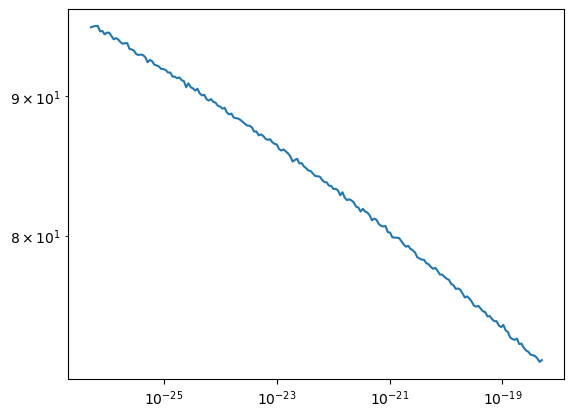

In [183]:
plt.plot(M / const.M_sol, sigmaM)

plt.xscale('log')
plt.yscale('log')


In [179]:
"%.3g" % (power_spec.M_cutoff(0.1, sigma=3.) / const.M_sol)


/tmp/ipykernel_3335146/2978062187.py:54: RuntimeWarning: invalid value encountered in power
  R = (3/(4*np.pi) * M / rho_m)**(1/3)


'1e+20'